## Simulation 

### Import Packages

In [1]:
""" Load packages """
import numpy as np
import matplotlib.pyplot as plt

### Define functions

In [2]:
""" Simulate interest rate paths by the Vasicek model """

def vasicek(parameters,parameters_general):  
    """
    Simulates several paths of a Vasicek process at finitely many points
    
    Arguments:
    parameters:           Contains the relevant parameters for the Vasicek model 
    parameters_general:   Contains general parameters for the time-grid and number of paths
    
    Returns:
    xi:       n x (m+1) Matrix with one simulated Vasicek process (over time) in each row. 
              In total we simulated n paths of the Vasicek model
    """   
    
    
    # Initialization of pseudorandom number generator: helps to  compare different settings 
    # Feel free to comment this if you don't need it 
    np.random.seed(20)

    # Retrieve parameters for the simple Vasicek model from dictionary "parameters"
    xi_0 = parameters['xi_0'] # initial value 
    kappa = parameters['kappa'] # speed of reversion
    theta = parameters['theta'] # long term mean level
    sigma = parameters['sigma'] # instantaneous volatility
    T = parameters_general['T'] # total time/maturity
    m = parameters_general['m'] # subintervals/discrete hedge points
    n = parameters_general['n'] # number of simulated paths
    
    # Generate Initial values of Vasicek model
    xi = np.reshape(np.repeat(np.array([xi_0]), [n]),(n,1))
       
    # Generate Values of Vasicek model for each time point
    dt = T/m  # difference in time - each subinterval
    vas_sigma = (sigma**2)*(1-np.exp(-2*kappa*dt))/(2*kappa) # Conditional variance
    
    for j in np.arange(1,m+1):        
        vas_mu = xi[:,j-1] * np.exp(-kappa*dt) + theta * (1 - np.exp(-kappa*dt)) # Conditional expectation
        xi_next = vas_mu + np.sqrt(vas_sigma)*np.random.normal(0,1,n)
        #xi_next = np.random.normal(vas_mu,np.sqrt(vas_sigma),n)
        xi_new = np.c_[xi,xi_next]
        xi = xi_new.copy()
        
    return xi

In [3]:
""" Simulate paths from the jump process J_t """

def jumps(parameters, parameters_general):
    '''
    Simulates several paths of jump process J_t from our affine multicurve example with discontinuites
    
    Arguments:
    parameters:           Contains the relevant parameters for the Jump process
    parameters_general:   Contains general parameters for the time-grid and number of paths
    
    Returns:
    J_t       n x (m+1) Matrix with one simulated Jump process in each row. 
              In total we simulated n paths of the Jump process
    t*m       discontinuity time points in days - needed for the plot
    ''' 
    
    # Initialization of pseudorandom number generator: helps to  compare different settings 
    # Feel free to comment this if you don't need it 
    np.random.seed(20)
    
    # Retrieve parameters for the Jump process from dictionary "parameters"
    kappa_3 = parameters['kappa_3'] # speed of reversion
    n_jumps = parameters['n_jumps'] # Number of deterministic discontinuity dates (e.g. ECB meeting, end of maintenance period)
                                    # Note: Here they are selected uniformly random so that we don't have to select them manually, 
                                    #       but they are chosen in advance and are fixed.
    factor = parameters['sd']       # Factor to control calculate normal distribution with different sd
    T = parameters_general['T'] # total time/maturity
    m = parameters_general['m'] # subintervals/discrete hedge points
    n = parameters_general['n'] # number of simulated paths
    
    # Generate randomly a fixed set of discontinuity dates. Those are known in advance, meant to be deterministic 
    # and (centered/standard) normal distributed random values at those dates
    T_n = np.random.uniform(low = 0, high = T, size = (n_jumps,1))
    T_n.sort(axis=0)
    Z = factor*np.random.normal(size=(n_jumps,n))
    
    # Calculate values  of Jump process at each time point for n paths
    ind = (T_n<=0)
    J_0 = np.dot(Z.T,ind)
    J_t = J_0.copy()
    for j in np.arange(1, m+1):
        ind = (T_n <= j*T/m)
        J_t_next = np.dot(ind.T,np.multiply(Z,np.exp(-kappa_3*(j*T/m-T_n))))
        J_new = np.c_[J_t,J_t_next.T]
        J_t = J_new.copy()
        
    return J_t, T_n*m

In [4]:
""" Simulate rate path by the multi-curve Vasicek model """

def vasicek_multi(parameters):  
    """
    Simulates several paths of a additive Vasicek process at finitely many points and with corelation rho
    
    Arguments:
    parameters: Contains the relevant parameters for the additive vasicek process
    
    Returns:
    r_delta     n x (m+1) Matrix with one simulated multi-curve/additive Vasicek process (over time) in each row.
                In total n simulated paths.
    """   
    
    # Initialization of pseudorandom number generator: helps to  compare different settings 
    # Feel free to comment this if you don't need it 
    np.random.seed(20)
    
    # Retrieve parameters for the Jump process from dictionary "parameters"
    xi_1_0 = parameters['xi_1']['xi_0'] # initial value of the Vasicek process xi_1
    kappa_1 = parameters['xi_1']['kappa'] # speed of reversion
    theta_1 = parameters['xi_1']['theta'] # long term mean level
    sigma_1 = parameters['xi_1']['sigma'] # instantaneous volatility
    xi_2_0 = parameters['xi_2']['xi_0'] #initial value of the Vasicek process xi_2
    kappa_2 = parameters['xi_2']['kappa'] # speed of reversion
    theta_2 = parameters['xi_2']['theta'] # long term mean level
    sigma_2 = parameters['xi_2']['sigma'] # instantaneous volatility
    rho = parameters['rho'] # correlation between Brownian motions of two vasicek processes
    T = parameters['general']['T'] # total time/maturity
    m = parameters['general']['m'] # subintervals/discrete hedge points
    n = parameters['general']['n'] # number of simulated paths

    # Generate two simple Vasicek models and calculate initial value of additive Vasicek model
    xi_1 = vasicek(parameters['xi_1'], parameters['general'])
    xi_2 = vasicek(parameters['xi_2'], parameters['general'])
    r_delta_0 = np.reshape(np.repeat(np.array([xi_1_0-xi_2_0]), [n]),(n,1))
    
    # Calcute additive Vasicek model
    dt = T/m   # difference in time each subinterval
    vas_mu = (xi_1 * np.exp(-kappa_1*dt) + theta_1 * (1 - np.exp(-kappa_1*dt))
             -xi_2 * np.exp(-kappa_2*dt) - theta_2 * (1 - np.exp(-kappa_2*dt))) # conditional expectation
    vas_sigma =  ( (sigma_1**2)*(1-np.exp(-2*kappa_1*dt))/(2*kappa_1) 
                 - 2*rho*(sigma_1*sigma_2)*(1-np.exp(-(kappa_1 + kappa_2)*dt))/(kappa_1 +kappa_2) 
                 + (sigma_2**2)*(1-np.exp(-2*kappa_2*dt))/(2*kappa_2) ) # conditional variance
    dummy = vas_mu + np.reshape(np.sqrt(vas_sigma)*np.random.normal(0,1,n),(n,1)) # generate normal distributed random variables
    r_delta = np.c_[r_delta_0,dummy[:,0:(dummy.shape[1]-1)]]

    return r_delta

### Parameter set 
If you want to see different specifications of the parameters tune here.

In [5]:
""" Define parameters

    Parameters for Vasicek models in dictionary parameters['xi_1'] and parameters['xi_2']
    @xi_0:    initial value 
    @kappa:   speed of reversion
    @theta:   long term mean level 
    @sigma:   instantaneous volatility
    
    Parameters for additive Vasicek model with correlation
    @rho:      correlation between Brownian motions of the two Vasicek-specifications
                
    Parameters for Jump process in dictionary parameters['jump']:
    @kappa_3:   speed of reversion/continuous drift parameter
    @n_jumps:   Number of deterministic discontinuity dates (ECB meeting, end of maintenance period)
                Note: Here they are selected uniformly random, but they have to be chosen in advance and be fixed.
    @sd:        Factor before normal distr: to calculate normal distribution with different sd
    
    Parameter needed to calculate the short rate f(t,t,delta)
    @a:         controls the different impact of the stochastic discontinuites on the spread (and hence, on the Ibor curve)
        
    Global parameters used for all processes:
    @T:         total time/maturity. Here we choose 1 year
    @m:         subintervals/discrete hedge points: We typically choose 252, 
                which is roughly the amount of trading  days in a year
    @n:         number of simulated paths
"""

# Generate a dictionary to store the parameters: 
# Tuning of parameters can be done here
parameters = {'xi_1': {'xi_0': 0.010, 'kappa': 0.2, 'theta': 0.03, 'sigma': 0.01},
              'xi_2': {'xi_0': 0.005, 'kappa': 1, 'theta': 0.002, 'sigma': 0.002},
              'rho': 0.8,
              'jump_directional': {'kappa_3': 0.01, 'n_jumps': 6, 'sd': 0.005},
              'jump_spiky': {'kappa_3': 20, 'n_jumps': 6, 'sd': 0.005},
              'a': 0.00001, 
              'general': {'T': 1., 'm': 252, 'n': 20}
             }

### Calculate and plot some rates

#### Simple vasicek

In [6]:
# Generate several paths for two different simple Vasicek models
xi_1 = vasicek(parameters['xi_1'],parameters['general'])
xi_2 = vasicek(parameters['xi_2'],parameters['general'])

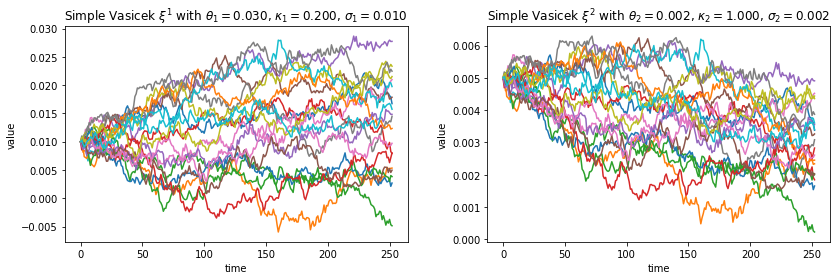

In [7]:
# Plot several paths of simple Vasicek models

# Plot the Vasicek model for the first parameter specification
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(xi_1.T);
plt.xlabel('time');
plt.ylabel('value');
plt.title(r'Simple Vasicek $\xi^1$ with $\theta_1 =$%1.3f, $\kappa_1 =$%1.3f, $\sigma_1=$%1.3f' 
          %(parameters['xi_1']['theta'],parameters['xi_1']['kappa'],parameters['xi_1']['sigma']));

# Plot the Vasicek model for the 2nd parameter specification
plt.subplot(1,2,2)
plt.plot(xi_2.T);
plt.xlabel('time');
plt.ylabel('value');
plt.title(r'Simple Vasicek $\xi^2$ with $\theta_2 =$%1.3f, $\kappa_2 =$%1.3f, $\sigma_2=$%1.3f'
          %(parameters['xi_2']['theta'],parameters['xi_2']['kappa'],parameters['xi_2']['sigma']));

plt.tight_layout()
plt.show()

#### Jump process

In [8]:
# Calculate the jump process for two different kappa_3 (kappa_3 = 0 corresponds to directional jumps. 
# The greater kappa_3 is the faster it will mean-revert

J_t_dir, T_n_dir = jumps(parameters['jump_directional'], parameters['general'])
J_t_spi, T_n_spi = jumps(parameters['jump_spiky'], parameters['general'])

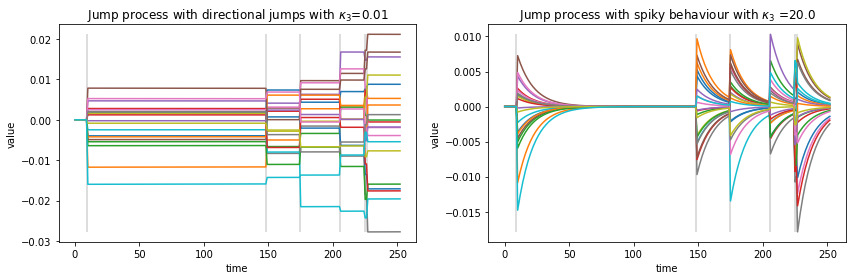

In [9]:
# Plot several paths of the Jump processes

plt.figure(figsize=(12, 4))

# Plot the jump process for the first choosen kappa_3
plt.subplot(1,2,1)
plt.plot(J_t_dir.T);
plt.vlines(T_n_dir, ymin = J_t_dir.min(), ymax = J_t_dir.max(), colors='lightgrey')
plt.xlabel('time');
plt.ylabel('value');
plt.title(r'Jump process with directional jumps with $\kappa_3$=%1.2f' %parameters['jump_directional']['kappa_3']);

# Plot the jump process for the second choosen kappa_3
plt.subplot(1,2,2)
plt.plot(J_t_spi.T);
plt.vlines(T_n_spi, ymin = J_t_spi.min(), ymax = J_t_spi.max(), colors='lightgrey')
plt.xlabel('time');
plt.ylabel('value');
plt.title(r'Jump process with spiky behaviour with $\kappa_3$ =%1.1f' %parameters['jump_spiky']['kappa_3']);

plt.tight_layout()
plt.show()

#### Short rate $f(t,t,0)$

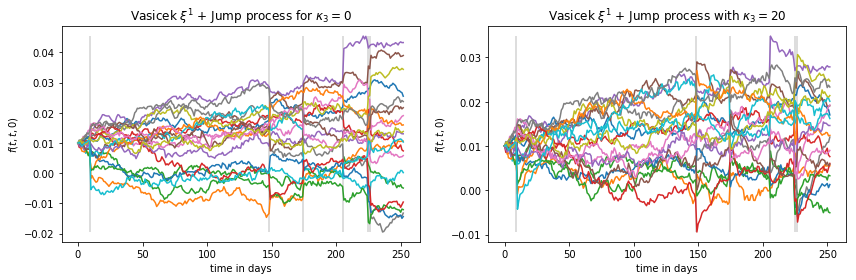

In [10]:
# Calculate the short rate f(t,t,0) for two different specifications of the jump process
f_tt_0_dir = xi_1.T + J_t_dir.T
f_tt_0_spi = xi_1.T + J_t_spi.T

# Plot the short rate for two different specifications of the jump process
plt.figure(figsize=(12, 4))

# Plot the short rate for the first choosen kappa_3
plt.subplot(1,2,1)
plt.vlines(T_n_dir, ymin = f_tt_0_dir.min(), ymax = f_tt_0_dir.max(), colors='lightgrey')
plt.plot(f_tt_0_dir);
plt.xlabel('time in days');
plt.ylabel(r'$f(t,t,0)$');
plt.title(r'Vasicek $\xi^1$ + Jump process for $\kappa_3 =$%i' %parameters['jump_directional']['kappa_3']);

# Plot the short rate for the second choosen kappa_3
plt.subplot(1,2,2)
plt.vlines(T_n_spi, ymin = f_tt_0_spi.min(), ymax = f_tt_0_spi.max(), colors='lightgrey')
plt.plot(f_tt_0_spi);
plt.xlabel('time in days');
plt.ylabel(r'$f(t,t,0)$');
plt.title(r'Vasicek $\xi^1$ + Jump process with $\kappa_3=%i$' %parameters['jump_spiky']['kappa_3']);

plt.tight_layout()
plt.show()

#### Additive Vasicek

In [11]:
# Generate several paths of the additive Vasicek model
r_delta = vasicek_multi(parameters)

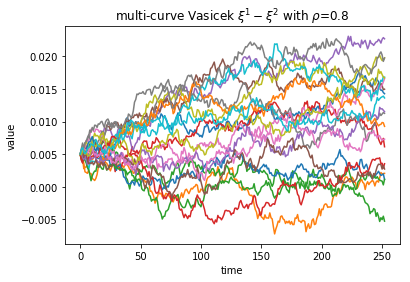

In [12]:
# Plot several paths of the additive Vasicek model
plt.plot(r_delta.T);
plt.xlabel('time');
plt.ylabel('value');
plt.title(r'multi-curve Vasicek $\xi^1 - \xi^2$ with $\rho$=%1.1f' %parameters['rho']);

#### Instantaneous rate $f(t,t,\delta)$

In [13]:
# Calculate the rate f(t,t,delta) for two different mean-reverting speed parameters of the jump process

f_tt_delta_dir = r_delta.T + (1 + parameters['a']*parameters['jump_directional']['kappa_3'])*J_t_dir.T
f_tt_delta_spi = r_delta.T + (1 + parameters['a']*parameters['jump_spiky']['kappa_3'])*J_t_spi.T

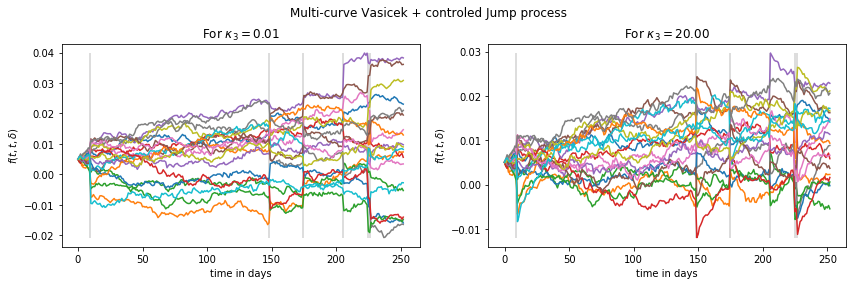

In [14]:
# Plot the instantaneous rate f(t,t,delta) 

plt.figure(figsize=(12, 4))

# Plot the instantaneous rate f(t,t,delta) for the first choosen kappa_3
plt.subplot(1,2,1)
plt.vlines(T_n_dir, ymin = f_tt_delta_dir.min(), ymax = f_tt_delta_dir.max(), colors='lightgrey')
plt.plot(f_tt_delta_dir);
plt.xlabel('time in days');
plt.ylabel(r'$f(t,t,\delta)$');
plt.title(r'For $\kappa_3=$%1.2f' %parameters['jump_directional']['kappa_3']);

# Plot the instantaneous rate f(t,t,delta) for the second choosen kappa_3
plt.subplot(1,2,2)
plt.vlines(T_n_spi, ymin = f_tt_delta_spi.min(), ymax = f_tt_delta_spi.max(), colors='lightgrey')
plt.plot(f_tt_delta_spi);
plt.xlabel('time in days');
plt.ylabel(r'$f(t,t,\delta)$');
plt.title(r'For $\kappa_3=$%1.2f' %parameters['jump_spiky']['kappa_3']);

plt.tight_layout()
plt.suptitle(r'Multi-curve Vasicek + controled Jump process')
plt.subplots_adjust(top=0.85)
plt.show()